In [66]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib as matplotlib, matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
def norm(x, axis=None):
    return np.sqrt(np.sum(np.array(x)**2, axis=axis))

# Optimization
## Michael McDermott

Optimization was conducted to improve the performance of the LJ Molecular Dynamics program. 

### Note on runtimes:
#### I discovered about halfway through my work that the run time is dependent on step size. Most of the benchmarking is done at 1e-12 s step, but the computation is all done at 1e-13 or 1e-14. I am not sure why this is, as the "virtual" time should have no influence over the actual run time, but my guess is it has to do with the relative frequency that the force calculation exits early. 

![iterspeed](./iterspeedpng.png)

### Bone-stock performance
#### Program was run on an i3-3120M 2.5 Ghz (4 threads). A typical speed benchmark consists of running with time step = 1e-12 seconds and end time = 1e-10.  Initialization (populating the simulation with atoms) is timed separately from iterations. Initialization time is fixed with respect to simulation. Iters/second are computed from after simulation. 
Compiling: `gcc main.c aux.c -lm -o plain.run`

    Number of iterations: 101
    Initialization seconds: 2.751
    Elapsed seconds: 22.519
    Iterations per second: 4.49
    
    Number of iterations: 101
    Initialization seconds: 2.684
    Elapsed seconds: 30.022
    Iterations per second: 3.36
    
    Number of iterations: 101
    Initialization seconds: 2.106
    Elapsed seconds: 21.016
    Iterations per second: 4.81


In [2]:
baseline = np.mean([4.49, 3.36, 4.81])
print("Baseline speed (iterations/sec): {:.2f}".format(baseline))

Baseline speed (iterations/sec): 4.22


## Pipe to file
#### This optimization seeks to eliminate some overhead by directly outputing to a file (bash > redirect) rather than standard out. This had no effect, however since future attempts would all be piping to a file, I wanted to control for this effect.

    Initialization seconds: 2.688
    Elapsed seconds: 29.506
    Iterations per second: 3.42

    Initialization seconds: 2.141
    Elapsed seconds: 20.995
    Iterations per second: 4.81

    Initialization seconds: 2.080
    Elapsed seconds: 21.157
    Iterations per second: 4.77


## Optimization flags
### -O1 - 2.5x improvement


    Elapsed seconds: 9.326
    Iterations per second: 10.83

    Elapsed seconds: 6.677
    Iterations per second: 15.13
    
    Elapsed seconds: 7.022
    Iterations per second: 14.38


### -O2

    Initialization seconds: 2.049
    Elapsed seconds: 8.594
    Iterations per second: 11.75

    Initialization seconds: 1.991
    Elapsed seconds: 8.921
    Iterations per second: 11.32

    Initialization seconds: 1.627
    Elapsed seconds: 6.439
    Iterations per second: 15.68
    
### -O3

    Initialization seconds: 2.072
    Elapsed seconds: 8.269
    Iterations per second: 12.21

    Initialization seconds: 1.604
    Elapsed seconds: 6.123
    Iterations per second: 16.50

    Initialization seconds: 1.618
    Elapsed seconds: 6.085
    Iterations per second: 16.60

#### Because O3 optimization provides a great effect with no cost to accuracy, it'll be used from here on out.



In [3]:
o3flag = np.mean([12.21, 16.5, 16.6])
print("O3 flag (it/sec): {:.2f}\nGain: {:.2f}x".format(o3flag, o3flag/baseline))

O3 flag (it/sec): 15.10
Gain: 3.58x


## Bogothreading
#### True hyperthreading with a simulation such as this is very challenging, since the entire system is interconnected. However, what can be done is run the experiment several times in parallel in order to improve the resolution/precision. I ran a long experiment with this method, however, because I forgot to modify the seed value, I ended up running the same experiment 5 times, and hence the histogram was the same for each. 

## Multithreading
#### With a fair bit of tweaking, I was able to split the most intensive part of the code, the force calculation (an O(n²) algorithm), by sending 1/n of the calculations to n threads (in my case 4 was ideal). Spawning a thread incurs a small overhead, on the order of 10 ms. However, given than an average loop is about  60 ms, by using 4 threads, I can theoretically get up to 40 iterations/second (15+10 ms each). Actual gain is 37.7 it/sec, or a ninefold speedup of the original code (2.5x O3 single threaded). 

    Elapsed seconds: 2.661
    Iterations per second: 37.96

    Elapsed seconds: 2.702
    Iterations per second: 37.39

    Elapsed seconds: 2.672
    Iterations per second: 37.79



In [12]:
thread4 = np.mean([37.96, 37.39, 37.79])
print("4 threads (it/sec): {:.2f}\nGain: {:.2f}x".format(thread4, thread4/baseline))
print("Gain w.r.t O3 single thread: {:.2f}x".format(thread4/o3flag))

4 threads (it/sec): 37.71
Gain: 8.94x
Gain w.r.t O3 single thread: 2.50x


# Speed histogram
#### An experiment was conducted at a step size of  1e-14 for 2 ns.  The final distribution of speed is shown in the histogram below. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3ecb8f0198>]], dtype=object)

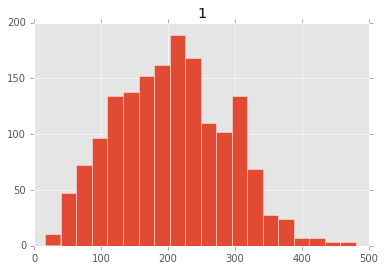

In [59]:
speeds = pd.read_csv('data/mean_spd.csv', sep=',', header=None, index_col=0).astype(float)
# data.hist(bins=30)
speeds.hist(bins=20)

# Speed over time

(200, 300)

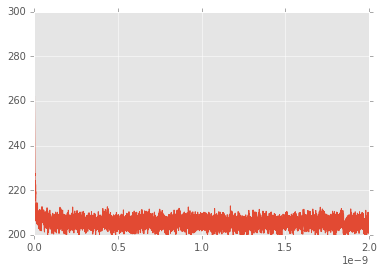

In [64]:
data = pd.read_csv('data/core5_1en14_2en9/bogo1b.txt', sep='\t').astype(float)
plt.plot(data['time [s]'], data['mean speed [m/s]'])
plt.ylim(200,300)

In [63]:
np.mean((np.diff(data['time [s]'])))

1.0000000000000002e-14

In [68]:
hep = pd.read_csv('out/hep_t4_dt14_m11_s555_e10.csv', sep='\t', header=None)
vel = np.diff(hep, axis=0)
spd = norm(vel, 1)
plt.plot(np.log(spd))